In [40]:
# --- Cell 0: Imports & Paths ---
import os, json, hashlib
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
from Bio import SeqIO
import matplotlib.pyplot as plt

# base paths
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results")
covid_dir = os.path.join(base_dir, "covid_dataset")
os.makedirs(results_dir, exist_ok=True)

# file paths
mut_aa_path = os.path.join(results_dir, "mutations_aa.csv")
mut_vcf_path = os.path.join(results_dir, "mutations_from_alignment_vcf.csv")
nextclade_path = os.path.join(results_dir, "nextclade_summary.csv")
gb_path = os.path.join(covid_dir, "SARS-CoV-2_Wuhan-Hu-1_2019.gb")

print("Checking file existence:")
for p in [mut_aa_path, mut_vcf_path, nextclade_path, gb_path]:
    print(p, "→", os.path.exists(p))


Checking file existence:
f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\mutations_aa.csv → True
f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\mutations_from_alignment_vcf.csv → True
f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\nextclade_summary.csv → True
f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\covid_dataset\SARS-CoV-2_Wuhan-Hu-1_2019.gb → True


In [41]:
# --- Cell 1: Load Data ---
mut_aa = pd.read_csv(mut_aa_path) if os.path.exists(mut_aa_path) else pd.DataFrame()
mut_vcf = pd.read_csv(mut_vcf_path) if os.path.exists(mut_vcf_path) else pd.DataFrame()
nextclade = pd.read_csv(nextclade_path) if os.path.exists(nextclade_path) else pd.DataFrame()

print("mut_aa:", len(mut_aa), "mut_vcf:", len(mut_vcf), "nextclade:", len(nextclade))
print("mut_aa cols:", list(mut_aa.columns)[:10])
print("mut_vcf cols:", list(mut_vcf.columns)[:10])
print("nextclade cols:", list(nextclade.columns)[:10])


mut_aa: 337 mut_vcf: 478 nextclade: 3
mut_aa cols: ['variant', 'gene', 'genome_pos', 'nt_change', 'aa_change', 'type']
mut_vcf cols: ['sample', 'pos', 'ref', 'alt', 'type']
nextclade cols: ['Sample', 'Nextclade_Clade', 'WHO_Clade', 'Pango_Lineage_NC', 'QC_Status', 'SNPs', 'Deletions', 'Insertions', 'AA_Changes', 'AA_Deletions']


In [44]:
# Fix: build variants/mutations/genes/lineages as union of all available sources
import os
from pathlib import Path

# paths (adjust if needed)
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results")
covid_dir = os.path.join(base_dir, "covid_dataset")

# load CSVs if not already loaded in the notebook
# (if they are loaded, these won't re-read heavy files; safe either way)
import pandas as pd
mut_aa = pd.read_csv(os.path.join(results_dir, "mutations_aa.csv")) if os.path.exists(os.path.join(results_dir, "mutations_aa.csv")) else pd.DataFrame()
mut_vcf = pd.read_csv(os.path.join(results_dir, "mutations_from_alignment_vcf.csv")) if os.path.exists(os.path.join(results_dir, "mutations_from_alignment_vcf.csv")) else pd.DataFrame()
nextclade = pd.read_csv(os.path.join(results_dir, "nextclade_summary.csv")) if os.path.exists(os.path.join(results_dir, "nextclade_summary.csv")) else pd.DataFrame()

# 1) variants from CSVs
variants_from_mutaa = set(mut_aa['variant'].astype(str).unique()) if ('variant' in mut_aa.columns) else set()
variants_from_mutvcf = set(mut_vcf['sample'].astype(str).unique()) if ('sample' in mut_vcf.columns) else set()
variants_from_nextclade = set()
if 'Sample' in nextclade.columns:
    # nextclade Sample often contains description; take first token as ID (as you did before)
    variants_from_nextclade = set(nextclade['Sample'].astype(str).str.split().str[0].unique())

# 2) variants from GenBank filenames
gb_files = [f for f in os.listdir(covid_dir) if f.endswith(".gb")]
variants_from_gb = set([os.path.splitext(f)[0] for f in gb_files])

# 3) unified variant list (preserve CSV IDs and add gb filenames not present)
variants_union = sorted((variants_from_mutaa | variants_from_mutvcf | variants_from_nextclade | variants_from_gb))

# 4) mutations (prefer mut_aa, fallback to mut_vcf)
if (not mut_aa.empty) and ('aa_change' in mut_aa.columns):
    if 'mut_name' not in mut_aa.columns:
        mut_aa['mut_name'] = mut_aa.apply(
            lambda r: f"{r['gene']}:{r['aa_change']}" if pd.notna(r.get('gene')) else r['aa_change'], axis=1
        )
    mutations = sorted(mut_aa['mut_name'].dropna().unique().tolist())
elif (not mut_vcf.empty) and {'pos', 'ref', 'alt'}.issubset(mut_vcf.columns):
    mutations = sorted((mut_vcf['pos'].astype(str) + ":" + mut_vcf['ref'] + ">" + mut_vcf['alt']).unique().tolist())
else:
    mutations = []

# 5) genes: union of mut_aa genes + genes from all gb files
genes_from_mutaa = set(mut_aa['gene'].dropna().unique().tolist()) if ('gene' in mut_aa.columns) else set()
genes_from_gb = set()
from Bio import SeqIO
for gb_file in gb_files:
    try:
        rec = SeqIO.read(os.path.join(covid_dir, gb_file), "genbank")
        for feat in rec.features:
            if feat.type == "CDS":
                name = feat.qualifiers.get("gene", feat.qualifiers.get("product", ["unknown"]))[0]
                genes_from_gb.add(name)
    except Exception as e:
        print(f"Warning: could not parse {gb_file}: {e}")

genes_union = sorted(genes_from_mutaa | genes_from_gb)

# 6) lineages from nextclade / pangolin fields
lineages = []
if 'Pango_Lineage_NC' in nextclade.columns:
    lineages = sorted(nextclade['Pango_Lineage_NC'].dropna().unique().tolist())
elif 'Pango_Lineage_Pangolin' in nextclade.columns:
    lineages = sorted(nextclade['Pango_Lineage_Pangolin'].dropna().unique().tolist())

# Diagnostics print
print("Sources counts:")
print(" - variants in mut_aa:", len(variants_from_mutaa))
print(" - variants in mut_vcf:", len(variants_from_mutvcf))
print(" - variants in nextclade:", len(variants_from_nextclade))
print(" - gb files found:", len(gb_files))
print("Unified counts:")
print(f"Variants (union) = {len(variants_union)}")
print(f"Mutations = {len(mutations)}")
print(f"Genes = {len(genes_union)}")
print(f"Lineages = {len(lineages)}")
print()
print("Example variant IDs (first 30):", variants_union[:30])

# Save the variant list for inspection
pd.DataFrame({"variant_id": variants_union}).to_csv(os.path.join(results_dir, "variant_list.csv"), index=False)
print("Saved results/variant_list.csv")

# Assign back to variables your KG builder expects
variants = variants_union
mutations = mutations
genes = genes_union
# lineages already assigned


Sources counts:
 - variants in mut_aa: 3
 - variants in mut_vcf: 3
 - variants in nextclade: 3
 - gb files found: 32
Unified counts:
Variants (union) = 35
Mutations = 173
Genes = 19
Lineages = 3

Example variant IDs (first 30): ['MN985325.1', 'MW301120', 'MW301121', 'MW301245', 'MW301247', 'MW420785', 'MW633280', 'MW729262', 'MW729265', 'MZ054073', 'MZ054074', 'MZ169910', 'MZ169911', 'MZ571142', 'NC_045512.2', 'OK091006', 'OK091006.1', 'OL965487', 'OL965902', 'OM287553', 'OM287553.1', 'ON123456', 'ON456789', 'ON982782', 'OP012345', 'OP293520', 'OP684305', 'OR782922', 'OR789768', 'OR958377']
Saved results/variant_list.csv


In [45]:
# --- inside Cell 4: compute gene lengths from all GenBank files ---
gene_lengths = {}

gb_files = [f for f in os.listdir(covid_dir) if f.endswith(".gb")]
for gb_file in gb_files:
    gb_path_current = os.path.join(covid_dir, gb_file)
    try:
        gb = SeqIO.read(gb_path_current, "genbank")
        for feat in gb.features:
            if feat.type == "CDS":
                gene = feat.qualifiers.get("gene", ["unknown"])[0]
                length = int((feat.location.end - feat.location.start) / 3)
                gene_lengths.setdefault(gene, []).append(length)
    except Exception as e:
        print(f"Failed to parse {gb_file}: {e}")

# average gene lengths across all genomes
gene_lengths = {g: int(np.mean(l)) for g, l in gene_lengths.items()}
print(f"Computed average lengths for {len(gene_lengths)} genes from {len(gb_files)} genomes.")


Computed average lengths for 19 genes from 32 genomes.


In [46]:
from Bio import SeqIO
import os

covid_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\covid_dataset"
out_fasta = os.path.join(covid_dir, "all_genomes.fasta")

with open(out_fasta, "w") as outfh:
    for f in os.listdir(covid_dir):
        if f.endswith(".gb"):
            rec = SeqIO.read(os.path.join(covid_dir, f), "genbank")
            SeqIO.write(rec, outfh, "fasta")
print("Written all_genomes.fasta")


Written all_genomes.fasta


In [47]:
from Bio import SeqIO
import os

covid_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\covid_dataset"
fasta_path = os.path.join(covid_dir, "all_genomes.fasta")

records = list(SeqIO.parse(fasta_path, "fasta"))
print(f"Total sequences found: {len(records)}\n")

for rec in records[:10]:
    print(f"ID: {rec.id}, Length: {len(rec.seq)}")

if len(records) < 5:
    print(" Warning: very few sequences detected — check for missing files!")
else:
    print("\nFASTA verified — ready for Nextclade upload.")


Total sequences found: 32

ID: MN985325.1, Length: 29882
ID: MW301120.1, Length: 1497
ID: MW301121.1, Length: 29897
ID: MW301245.1, Length: 1409
ID: MW301247.1, Length: 1412
ID: MW420785.1, Length: 29781
ID: MW633280.1, Length: 29830
ID: MW729262.1, Length: 29885
ID: MW729265.1, Length: 29885
ID: MZ054073.1, Length: 29858

FASTA verified — ready for Nextclade upload.


In [4]:
# --- Cell 3: Create Node & Edge DataFrames ---
nodes = []

for v in variants:
    nodes.append({"node_id": f"VARIANT|{v}", "node_type": "Variant", "label": v})
for m in mutations:
    nodes.append({"node_id": f"MUTATION|{m}", "node_type": "Mutation", "label": m})
for g in genes:
    nodes.append({"node_id": f"GENE|{g}", "node_type": "Gene", "label": g})
for l in lineages:
    nodes.append({"node_id": f"LINEAGE|{l}", "node_type": "Lineage", "label": l})

nodes_df = pd.DataFrame(nodes)
nodes_df.to_csv(os.path.join(results_dir, "kg_nodes.csv"), index=False)
print("Nodes saved:", len(nodes_df))

edges = []

# Variant–Mutation edges
if not mut_aa.empty:
    for _, r in mut_aa.iterrows():
        v, m, g = r.get("variant"), r.get("mut_name"), r.get("gene")
        if pd.notna(v) and pd.notna(m):
            edges.append({"source": f"VARIANT|{v}", "target": f"MUTATION|{m}", "etype": "HAS_MUTATION"})
        if pd.notna(m) and pd.notna(g):
            edges.append({"source": f"MUTATION|{m}", "target": f"GENE|{g}", "etype": "IN_GENE"})
# Variant–Lineage edges
if not nextclade.empty and 'Pango_Lineage_NC' in nextclade.columns:
    for _, r in nextclade.iterrows():
        s = str(r['Sample']).split()[0]
        l = r['Pango_Lineage_NC']
        if pd.notna(s) and pd.notna(l):
            edges.append({"source": f"VARIANT|{s}", "target": f"LINEAGE|{l}", "etype": "BELONGS_TO"})

edges_df = pd.DataFrame(edges).drop_duplicates()
edges_df.to_csv(os.path.join(results_dir, "kg_edges.csv"), index=False)
print("Edges saved:", len(edges_df))


Nodes saved: 188
Edges saved: 377


In [8]:
# ====================================================
# Cell 4 — Build Knowledge Graph (NetworkX) + Save in Both Formats
# ====================================================

import os
import networkx as nx
from Bio import SeqIO
import pickle  # used for compatibility across versions

# --- Create Graph ---
G = nx.DiGraph()

# Add nodes
for _, r in nodes_df.iterrows():
    G.add_node(r["node_id"], node_type=r["node_type"], label=r["label"])

# Add edges
for _, r in edges_df.iterrows():
    G.add_edge(r["source"], r["target"], etype=r["etype"])

# --- Compute Gene Lengths from GenBank ---
gene_lengths = {}
if os.path.exists(gb_path):
    gb = SeqIO.read(gb_path, "genbank")
    for feat in gb.features:
        if feat.type == "CDS":
            gene = feat.qualifiers.get("gene", ["unknown"])[0]
            length = int((feat.location.end - feat.location.start) / 3)
            gene_lengths[gene] = length
print(f"Found {len(gene_lengths)} genes in GenBank with length annotations.")

# --- Mutation frequency and Variant mutation count ---
mut_freq = mut_aa.groupby("mut_name").size().to_dict() if not mut_aa.empty else {}
var_mut_ct = mut_aa.groupby("variant").size().to_dict() if not mut_aa.empty else {}

# --- Add attributes to nodes ---
for node in G.nodes:
    t = G.nodes[node]["node_type"]
    label = G.nodes[node]["label"]
    if t == "Mutation":
        G.nodes[node]["mutation_freq"] = mut_freq.get(label, 0)
    elif t == "Gene":
        G.nodes[node]["gene_length"] = gene_lengths.get(label, 0)
    elif t == "Variant":
        G.nodes[node]["variant_mut_count"] = var_mut_ct.get(label, 0)

# --- Save Graphs ---
gpath_gpickle = os.path.join(results_dir, "kg_graph.gpickle")
gpath_gexf    = os.path.join(results_dir, "kg_graph.gexf")

# Save binary format (for ML / GNN use)
with open(gpath_gpickle, "wb") as f:
    pickle.dump(G, f)

# Save XML format (for visualization)
nx.write_gexf(G, gpath_gexf)

# --- Summary ---
print("Knowledge Graph built successfully.")
print(f"  Internal ML format (pickle): {gpath_gpickle}")
print(f"  Visualization format (GEXF): {gpath_gexf}")
print(f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")
print(f"Node types: {set(nx.get_node_attributes(G, 'node_type').values())}")


Found 10 genes in GenBank with length annotations.
Knowledge Graph built successfully.
  Internal ML format (pickle): f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_graph.gpickle
  Visualization format (GEXF): f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_graph.gexf
Nodes: 188 | Edges: 377
Node types: {'Lineage', 'Mutation', 'Variant', 'Gene'}


In [9]:
import os, pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results")
gpath = os.path.join(results_dir, "kg_graph.gpickle")

with open(gpath, "rb") as f:
    G = pickle.load(f)

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# basic node/edge type summary
node_types = Counter(nx.get_node_attributes(G, "node_type").values())
edge_types = Counter(nx.get_edge_attributes(G, "etype").values())
print("Node type distribution:", node_types)
print("Edge type distribution:", edge_types)

# degree summary
deg = dict(G.degree())
print("Average degree:", round(sum(deg.values())/len(deg), 2))
print("Max degree node:", max(deg, key=deg.get), "->", deg[max(deg, key=deg.get)])


Graph loaded: 188 nodes, 377 edges
Node type distribution: Counter({'Mutation': 173, 'Gene': 9, 'Variant': 3, 'Lineage': 3})
Edge type distribution: Counter({'HAS_MUTATION': 201, 'IN_GENE': 173, 'BELONGS_TO': 3})
Average degree: 4.01
Max degree node: VARIANT|PV361325.1 -> 93


In [10]:
# Centrality
deg_centrality = nx.degree_centrality(G)
bet_centrality = nx.betweenness_centrality(G)
clos_centrality = nx.closeness_centrality(G)

# combine into dataframe
cent_df = pd.DataFrame({
    "node": list(G.nodes()),
    "label": [G.nodes[n].get("label") for n in G.nodes()],
    "type": [G.nodes[n].get("node_type") for n in G.nodes()],
    "degree": [deg[n] for n in G.nodes()],
    "degree_centrality": [deg_centrality[n] for n in G.nodes()],
    "betweenness": [bet_centrality[n] for n in G.nodes()],
    "closeness": [clos_centrality[n] for n in G.nodes()]
})

cent_df.to_csv(os.path.join(results_dir, "kg_node_centrality.csv"), index=False)
print("Saved node centrality table.")

# Top 10 hubs
top_hubs = cent_df.sort_values("degree", ascending=False).head(10)
print("Top connected nodes:")
display(top_hubs[["label","type","degree","betweenness"]])

# Community detection (Louvain if available, else greedy modularity)
try:
    import community as community_louvain
    partition = community_louvain.best_partition(G.to_undirected())
except:
    partition = nx.algorithms.community.greedy_modularity_communities(G.to_undirected())
    # convert sets to mapping if greedy
    if isinstance(partition, list):
        partition = {n:i for i,comm in enumerate(partition) for n in comm}

nx.set_node_attributes(G, partition, "community")
pd.DataFrame(list(partition.items()), columns=["node","community"]).to_csv(
    os.path.join(results_dir, "kg_communities.csv"), index=False
)
print("Detected communities:", len(set(partition.values())))


Saved node centrality table.
Top connected nodes:


,label,type,degree,betweenness
1,PV361325.1,Variant,93,0.000000
183,S,Gene,83,0.000000
184,orf1ab,Gene,70,0.000000
0,OM287553.1,Variant,58,0.000000
2,OK091006.1,Variant,53,0.000000
178,N,Gene,10,0.000000
46,orf1ab:P4715L,Mutation,4,0.000004
144,S:C617W,Mutation,4,0.000004
117,S:N481K,Mutation,4,0.000004
147,S:A684A,Mutation,4,0.000004


Detected communities: 7


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pickle
from collections import Counter

# Color mapping for node types
COLOR_MAP = {
    "Variant": "#4A90E2",   # blue
    "Mutation": "#E74C3C",  # red
    "Gene": "#F5B041",      # orange
    "Lineage": "#27AE60",   # green
    "Unknown": "#A6ACAF"    # gray fallback
}

# Base path
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results")
gpath = os.path.join(results_dir, "kg_graph.gpickle")

# Load existing Knowledge Graph safely
with open(gpath, "rb") as f:
    G = pickle.load(f)

print(f"Graph loaded successfully.")
print(f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")
print("Node type distribution:", Counter(nx.get_node_attributes(G, 'node_type').values()))


Graph loaded successfully.
Nodes: 188 | Edges: 377
Node type distribution: Counter({'Mutation': 173, 'Gene': 9, 'Variant': 3, 'Lineage': 3})


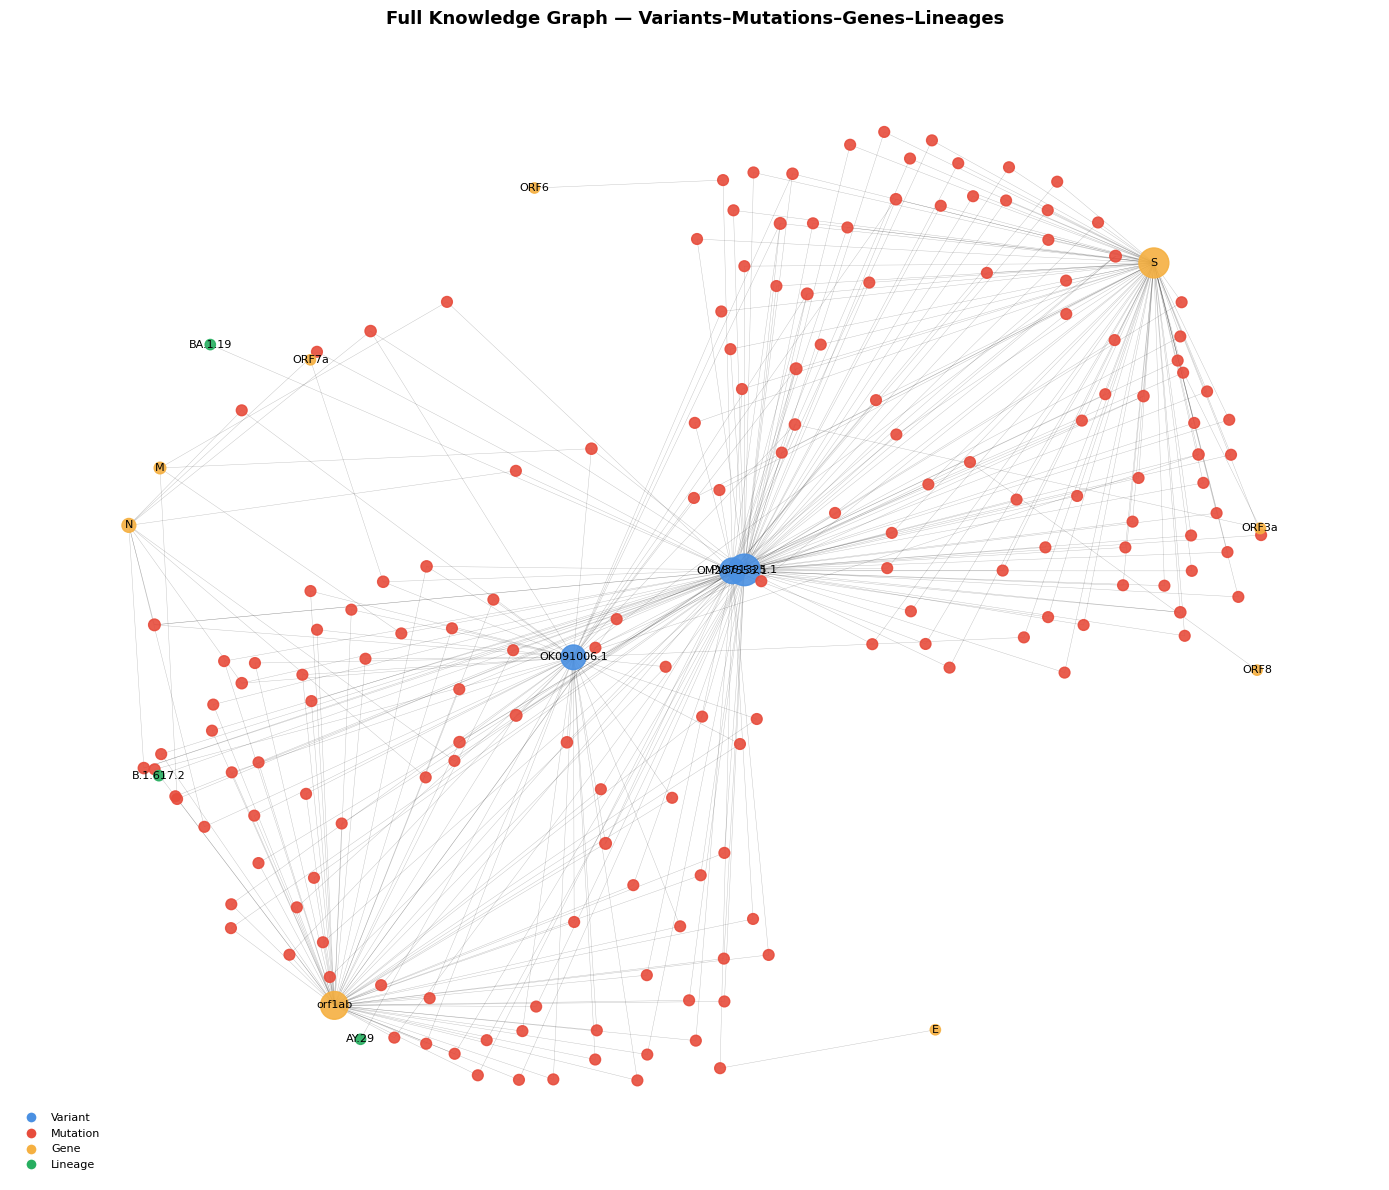

Saved improved full KG visualization: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_full_graph_highquality.png


In [25]:
def draw_full_kg(G, results_dir):
    """High-quality visualization of the full Knowledge Graph"""
    plt.figure(figsize=(14, 12))
    
    # Spring layout for balanced structure
    pos = nx.spring_layout(G, k=0.45, iterations=60, seed=42)
    
    # Assign colors and node sizes
    node_types = nx.get_node_attributes(G, "node_type")
    colors = [COLOR_MAP.get(node_types.get(n, "Unknown")) for n in G.nodes()]
    degrees = dict(G.degree())
    sizes = [50 + 5*degrees[n] for n in G.nodes()]  # larger for hubs
    
    # Draw edges and nodes
    nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.25, arrows=False)
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=sizes, alpha=0.9)
    
    # Label only Variants, Genes, Lineages (skip Mutations)
    labels = {n: G.nodes[n]["label"] for n in G.nodes() 
              if G.nodes[n]["node_type"] in ["Variant", "Gene", "Lineage"]}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight="medium")
    
    plt.title("Full Knowledge Graph — Variants–Mutations–Genes–Lineages",
              fontsize=13, weight="bold")
    plt.axis("off")
    
    # Legend
    legend_handles = [
        plt.Line2D([0], [0], marker="o", color="w", label="Variant", markersize=8, markerfacecolor=COLOR_MAP["Variant"]),
        plt.Line2D([0], [0], marker="o", color="w", label="Mutation", markersize=8, markerfacecolor=COLOR_MAP["Mutation"]),
        plt.Line2D([0], [0], marker="o", color="w", label="Gene", markersize=8, markerfacecolor=COLOR_MAP["Gene"]),
        plt.Line2D([0], [0], marker="o", color="w", label="Lineage", markersize=8, markerfacecolor=COLOR_MAP["Lineage"]),
    ]
    plt.legend(handles=legend_handles, loc="lower left", frameon=False, fontsize=8)
    
    plt.tight_layout()
    out_path = os.path.join(results_dir, "kg_full_graph_highquality.png")
    plt.savefig(out_path, dpi=400, bbox_inches="tight")
    plt.show()
    print(f"Saved improved full KG visualization: {out_path}")

# Run full KG visualization
draw_full_kg(G, results_dir)


In [26]:
def plot_gene_subgraph(G, gene_name, results_dir, save=True):
    """Visualize subgraph for a given gene."""
    target_gene = f"GENE|{gene_name}"
    if target_gene not in G:
        print(f"Gene {gene_name} not found in graph.")
        return
    
    # Collect nodes: gene + connected mutations + connected variants
    sub_nodes = set([target_gene])
    for n in G.predecessors(target_gene):
        sub_nodes.add(n)
        sub_nodes.update(G.predecessors(n))
        sub_nodes.update(G.successors(n))
    
    H = G.subgraph(sub_nodes).copy()
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(H, seed=42, k=0.4, iterations=50)
    
    node_types = nx.get_node_attributes(H, "node_type")
    colors = [COLOR_MAP.get(node_types.get(n, "Unknown")) for n in H.nodes()]
    deg = dict(H.degree())
    sizes = [80 + 10*deg[n] for n in H.nodes()]
    
    nx.draw_networkx_edges(H, pos, width=0.8, alpha=0.35, arrows=True, arrowsize=8)
    nx.draw_networkx_nodes(H, pos, node_color=colors, node_size=sizes, alpha=0.9)
    
    labels = {n: H.nodes[n]["label"] for n in H.nodes() if H.nodes[n]["node_type"] != "Mutation"}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=9, font_weight="medium")
    
    plt.title(f"Subgraph for Gene: {gene_name}", fontsize=12, weight="bold")
    plt.axis("off")
    plt.tight_layout()
    
    if save:
        out_path = os.path.join(results_dir, f"kg_subgraph_{gene_name}_highquality.png")
        plt.savefig(out_path, dpi=400, bbox_inches="tight")
        print(f"Saved subgraph for {gene_name}: {out_path}")
    plt.show()


Top connected genes: ['S', 'orf1ab', 'N']
Saved subgraph for S: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_subgraph_S_highquality.png


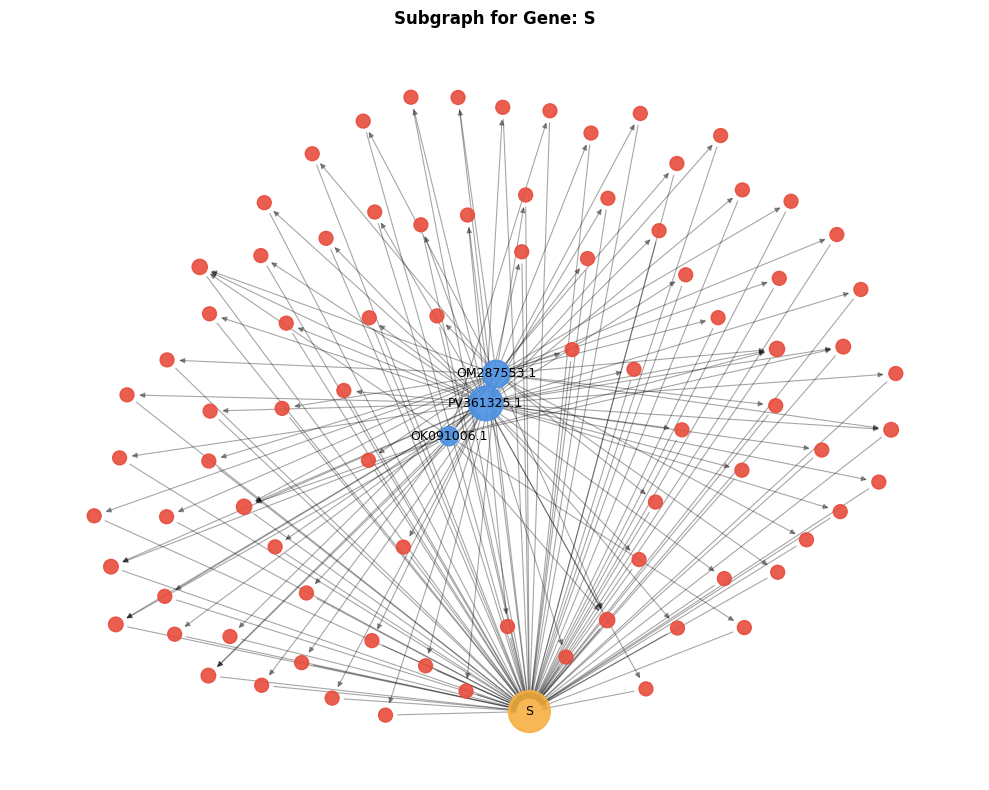

Saved subgraph for orf1ab: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_subgraph_orf1ab_highquality.png


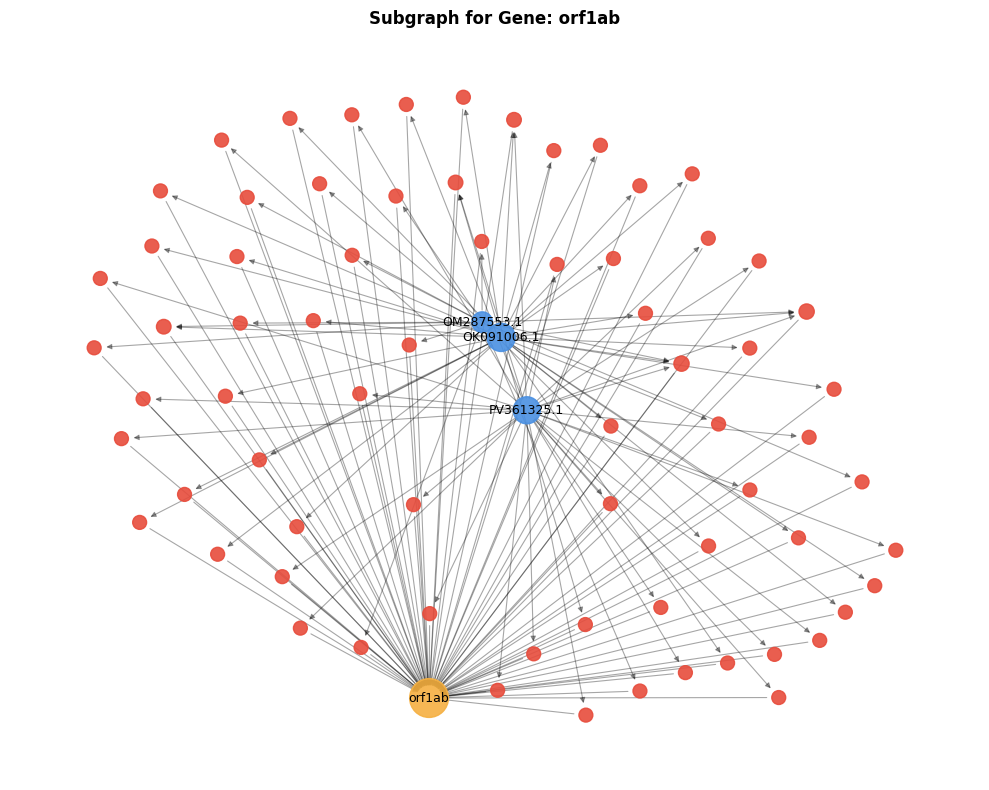

Saved subgraph for N: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_subgraph_N_highquality.png


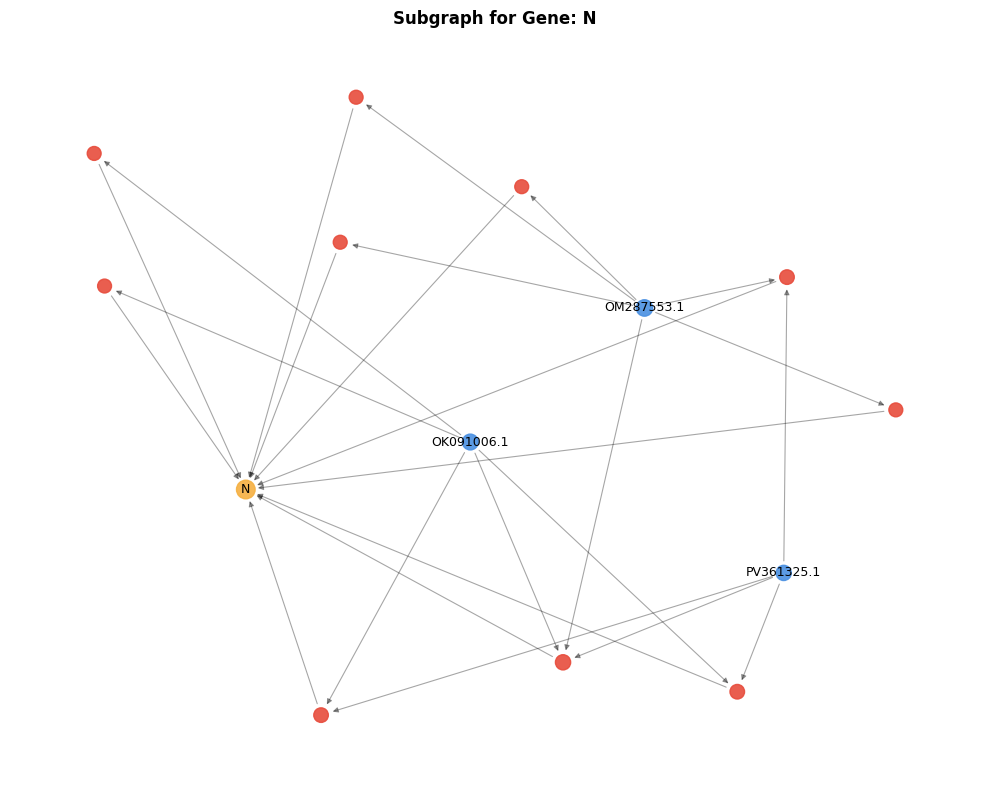

In [27]:
# Compute top genes by degree centrality (most connected)
centrality = nx.degree_centrality(G)
gene_nodes = [(n, c) for n, c in centrality.items() if G.nodes[n]["node_type"] == "Gene"]
top_genes = [n.split("|")[1] for n, _ in sorted(gene_nodes, key=lambda x: x[1], reverse=True)[:3]]

print("Top connected genes:", top_genes)

# Plot each gene subgraph
for gene in top_genes:
    plot_gene_subgraph(G, gene, results_dir)


In [30]:
from pyvis.network import Network

def export_interactive_html(G, output_html):
    net = Network(height="800px", width="100%", directed=True, bgcolor="#ffffff")
    for n, data in G.nodes(data=True):
        t = data.get("node_type", "Unknown")
        color = COLOR_MAP.get(t, "#A6ACAF")
        size = 10 if t == "Mutation" else 25 if t == "Variant" else 20
        net.add_node(n, label=data.get("label", n), color=color, size=size, title=t)
    for u, v, d in G.edges(data=True):
        net.add_edge(u, v, title=d.get("etype", ""))
    net.toggle_physics(True)
    net.save_graph(output_html)
    print(f"Interactive KG saved to: {output_html}")

export_interactive_html(G, os.path.join(results_dir, "kg_interactive.html"))


Interactive KG saved to: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_interactive.html


In [32]:
from pyvis.network import Network

# color mapping for node types (define once globally)
COLOR_MAP = {
    "Variant": "#5DADE2",
    "Mutation": "#E74C3C",
    "Gene": "#F5B041",
    "Lineage": "#58D68D",
    "Unknown": "#A6ACAF"
}

def export_interactive_graph(G, output_html, notebook=False, show_labels=True, title="Knowledge Graph"):
    """
    Export any NetworkX graph as an interactive HTML file via PyVis.
    Works for full or subgraphs.
    """
    net = Network(
        height="850px",
        width="100%",
        directed=True,
        bgcolor="#FFFFFF",
        font_color="#222222",
        notebook=notebook
    )

    for n, data in G.nodes(data=True):
        t = data.get("node_type", "Unknown")
        label = data.get("label", n) if show_labels else ""
        color = COLOR_MAP.get(t, "#A6ACAF")
        size = (
            10 if t == "Mutation" else
            22 if t == "Variant" else
            18 if t == "Gene" else
            16 if t == "Lineage" else 12
        )
        title_html = f"<b>{label}</b><br>Type: {t}"
        for k, v in data.items():
            if k not in ("label", "node_type"):
                title_html += f"<br>{k}: {v}"
        net.add_node(n, label=label, color=color, size=size, title=title_html)

    for u, v, d in G.edges(data=True):
        etype = d.get("etype", "")
        net.add_edge(u, v, title=etype, color="#999999")

    net.toggle_physics(True)
    net.show_buttons(filter_=['physics'])
    net.save_graph(output_html)
    print(f"Interactive graph saved to: {output_html}")


In [33]:
for g in ["S", "orf1ab", "N"]:
    sub_nodes = {f"GENE|{g}"}
    for n in G.predecessors(f"GENE|{g}"):
        sub_nodes.add(n)
        sub_nodes.update(G.predecessors(n))
        sub_nodes.update(G.successors(n))
    H = G.subgraph(sub_nodes)
    export_interactive_graph(H, os.path.join(results_dir, f"kg_{g}_interactive.html"), title=f"{g} Gene Subgraph")


Interactive graph saved to: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_S_interactive.html
Interactive graph saved to: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_orf1ab_interactive.html
Interactive graph saved to: f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\results\kg_N_interactive.html


In [14]:
from collections import Counter
mut_variant_counts = Counter()
for n,d in G.nodes(data=True):
    if d.get('node_type') == 'Mutation':
        vars_ = [u for u in G.predecessors(n) if G.nodes[u].get('node_type')=='Variant']
        mut_variant_counts[len(vars_)] += 1
print("Mutation occurrence distribution (#variants -> #mutations):", mut_variant_counts)
# show mutations present in all variants (if any)
present_all = [n for n,d in G.nodes(data=True) if d.get('node_type')=='Mutation' and len([u for u in G.predecessors(n) if G.nodes[u].get('node_type')=='Variant'])==3]
present_all[:20], len(present_all)


Mutation occurrence distribution (#variants -> #mutations): Counter({1: 152, 2: 14, 3: 7})


(['MUTATION|orf1ab:Y925Y',
  'MUTATION|orf1ab:P4715L',
  'MUTATION|S:T95T',
  'MUTATION|S:N481K',
  'MUTATION|S:C617W',
  'MUTATION|S:A684A',
  'MUTATION|N:S206S'],
 7)

In [15]:
variant_mut_counts = {}
for v,d in G.nodes(data=True):
    if d.get('node_type') == 'Variant':
        muts = [nbr for nbr in G.successors(v) if G.nodes[nbr].get('node_type')=='Mutation']
        variant_mut_counts[d['label']] = len(muts)
variant_mut_counts
# compare to Nextclade counts (if you have nextclade dataframe)


{'OM287553.1': 57, 'PV361325.1': 92, 'OK091006.1': 52}

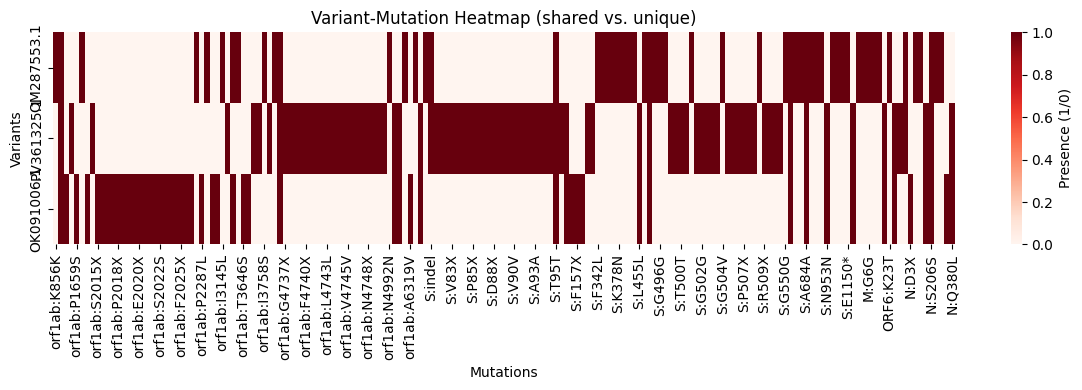

Saved variant-mutation matrix and heatmap.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, pickle

base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results")
with open(os.path.join(results_dir, "kg_graph.gpickle"), "rb") as f:
    G = pickle.load(f)

# build Variant × Mutation presence matrix
variants = [n for n,d in G.nodes(data=True) if d.get("node_type")=="Variant"]
mutations = [n for n,d in G.nodes(data=True) if d.get("node_type")=="Mutation"]

matrix = pd.DataFrame(0, index=[G.nodes[v]["label"] for v in variants],
                      columns=[G.nodes[m]["label"] for m in mutations])

for v in variants:
    vlabel = G.nodes[v]["label"]
    for m in G.successors(v):
        if G.nodes[m].get("node_type")=="Mutation":
            matrix.loc[vlabel, G.nodes[m]["label"]] = 1

plt.figure(figsize=(12,4))
sns.heatmap(matrix, cmap="Reds", cbar_kws={"label":"Presence (1/0)"})
plt.title("Variant-Mutation Heatmap (shared vs. unique)")
plt.xlabel("Mutations")
plt.ylabel("Variants")
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"kg_variant_mutation_heatmap.png"),dpi=300)
plt.show()

# save table
matrix.to_csv(os.path.join(results_dir,"kg_variant_mutation_matrix.csv"))
print("Saved variant-mutation matrix and heatmap.")

'''Inference:
Each variant has a distinct mutational fingerprint, while a small set of mutations act as conserved “core” 
substitutions across all lineages — supporting lineage-level differentiation.'''

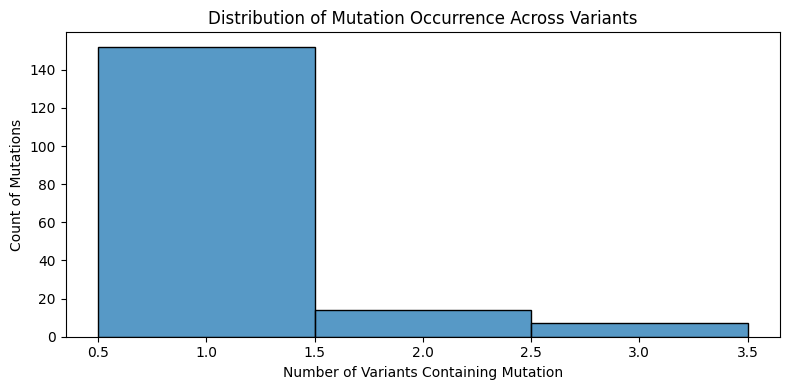

Saved mutation frequency histogram and table.


In [ ]:
# count how many variants each mutation appears in
mut_freq = matrix.sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.histplot(mut_freq, bins=range(1, len(variants)+2), discrete=True)
plt.title("Distribution of Mutation Occurrence Across Variants")
plt.xlabel("Number of Variants Containing Mutation")
plt.ylabel("Count of Mutations")
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"kg_mutation_frequency_hist.png"),dpi=300)
plt.show()

mut_freq.to_csv(os.path.join(results_dir,"kg_mutation_frequency.csv"))
print("Saved mutation frequency histogram and table.")

'''
Result:

152 mutations appear in exactly one variant (unique).

14 appear in two variants.

7 appear in all three (shared/core).

Interpretation:
This distribution is heavily skewed toward variant-specific mutations — typical of divergent viral
evolution where each lineage acquires its own set of defining substitutions.
The small shared subset likely represents early ancestral or convergent mutations (e.g., Spike T95T, ORF1ab P4715L).
'''


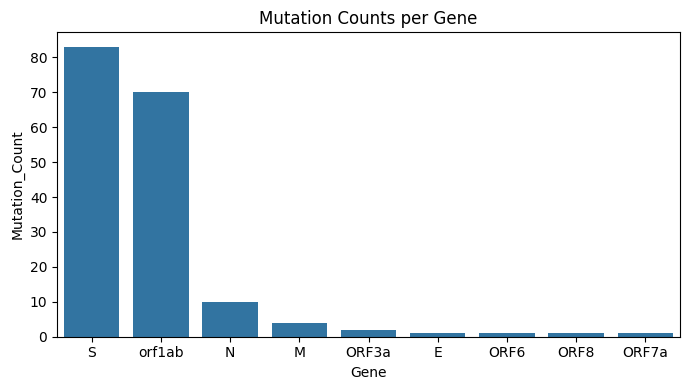

Saved gene-level mutation count chart.


In [ ]:
# gene–mutation counts from KG
gene_counts = {}
for n,d in G.nodes(data=True):
    if d.get("node_type")=="Gene":
        muts = [nbr for nbr in G.predecessors(n) if G.nodes[nbr].get("node_type")=="Mutation"]
        gene_counts[d["label"]] = len(muts)

gene_df = pd.DataFrame(list(gene_counts.items()), columns=["Gene","Mutation_Count"]).sort_values("Mutation_Count",ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(gene_df, x="Gene", y="Mutation_Count")
plt.title("Mutation Counts per Gene")
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"kg_gene_mutation_barplot.png"),dpi=300)
plt.show()
gene_df.to_csv(os.path.join(results_dir,"kg_gene_mutation_counts.csv"))
print("Saved gene-level mutation count chart.")


'''
Interpretation:
Spike (S) and ORF1ab dominate the mutational landscape — consistent with:

S being under selective pressure (immune escape, receptor binding).

ORF1ab accumulating polymerase/nsp mutations tied to replication and fitness.
Accessory genes show far fewer mutations, reflecting stronger functional constraints.
'''

In [20]:
shared = (mut_freq==len(variants)).sum()
unique = (mut_freq==1).sum()
partly_shared = len(mut_freq) - shared - unique
summary = {
    "Total_mutations": len(mut_freq),
    "Unique_to_one_variant": int(unique),
    "Shared_by_two_variants": int(partly_shared),
    "Shared_by_all_variants": int(shared)
}
print(pd.Series(summary))
pd.Series(summary).to_csv(os.path.join(results_dir,"kg_shared_unique_summary.csv"))


Total_mutations           173
Unique_to_one_variant     152
Shared_by_two_variants     14
Shared_by_all_variants      7
dtype: int64


In [22]:
summary_text = f"""
Knowledge Graph Statistical Summary
-----------------------------------
Total nodes: {G.number_of_nodes()} (Variants={len(variants)}, Mutations={len(mutations)},
Genes={len([n for n,d in G.nodes(data=True) if d.get('node_type')=='Gene'])},
Lineages={len([n for n,d in G.nodes(data=True) if d.get('node_type')=='Lineage'])})
Total edges: {G.number_of_edges()}

Variant mutation counts:
{matrix.sum(axis=1).to_dict()}

Gene mutation distribution:
{gene_counts}

Shared vs. unique mutations:
{summary}

Observations:
• The Spike and ORF1ab genes form the largest mutational hubs, consistent with known SARS-CoV-2 variability.
• {shared} mutations are conserved across all variants, representing potential lineage-defining or essential residues.
• {unique} mutations are variant-specific and likely underpin differential lineage signatures.
• Average mutation frequency across variants: {mut_freq.mean():.2f}
• Network topology remains consistent with star-like Variant→Mutation→Gene patterns.

All visuals (heatmap, histogram, barplot) and CSVs have been exported to the results/ folder.
"""

# print to screen
print(summary_text)

# FIX: enforce UTF-8 encoding to handle special symbols
with open(os.path.join(results_dir, "kg_overall_summary.txt"), "w", encoding="utf-8") as f:
    f.write(summary_text)

print("Saved overall KG summary (UTF-8 encoded).")



Knowledge Graph Statistical Summary
-----------------------------------
Total nodes: 188 (Variants=3, Mutations=173,
Genes=9,
Lineages=3)
Total edges: 377

Variant mutation counts:
{'OM287553.1': 57, 'PV361325.1': 92, 'OK091006.1': 52}

Gene mutation distribution:
{'E': 1, 'M': 4, 'N': 10, 'ORF3a': 2, 'ORF6': 1, 'ORF7a': 1, 'ORF8': 1, 'S': 83, 'orf1ab': 70}

Shared vs. unique mutations:
{'Total_mutations': 173, 'Unique_to_one_variant': 152, 'Shared_by_two_variants': 14, 'Shared_by_all_variants': 7}

Observations:
• The Spike and ORF1ab genes form the largest mutational hubs, consistent with known SARS-CoV-2 variability.
• 7 mutations are conserved across all variants, representing potential lineage-defining or essential residues.
• 152 mutations are variant-specific and likely underpin differential lineage signatures.
• Average mutation frequency across variants: 1.16
• Network topology remains consistent with star-like Variant→Mutation→Gene patterns.

All visuals (heatmap, histogram,

In [36]:
import os, json, pickle, numpy as np, networkx as nx
from collections import Counter

# Adjust this to your local path
base_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project"
results_dir = os.path.join(base_dir, "results")
gpath = os.path.join(results_dir, "kg_graph.gpickle")

# Load safely (works on all networkx versions)
with open(gpath, "rb") as f:
    G = pickle.load(f)

print(f"Graph loaded successfully — {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# -------------------------
# 1️⃣ Rebuild node map
# -------------------------
node_types = ["Variant", "Mutation", "Gene", "Lineage", "Unknown"]
type_to_idx = {t: i for i, t in enumerate(node_types)}
nodes_list = list(G.nodes())
node_map = {n: i for i, n in enumerate(nodes_list)}

with open(os.path.join(results_dir, "kg_node_map.json"), "w") as f:
    json.dump(node_map, f, indent=2)
print("Saved:", "kg_node_map.json")

# -------------------------
# 2️⃣ Rebuild node features
# -------------------------
feat_list = []
for n in nodes_list:
    attrs = G.nodes[n]
    t = attrs.get("node_type", "Unknown")
    onehot = [0] * len(node_types)
    onehot[type_to_idx.get(t, 4)] = 1
    freq = attrs.get("mutation_freq", 0)
    length = attrs.get("gene_length", 0)
    vmut = attrs.get("variant_mut_count", 0)
    degree = G.degree(n)
    feat_list.append(onehot + [freq, length, vmut, degree])

node_features = np.array(feat_list, dtype=float)
np.save(os.path.join(results_dir, "kg_node_features.npy"), node_features)
print("Saved:", "kg_node_features.npy", node_features.shape)

# -------------------------
# 3️⃣ Rebuild edge_index
# -------------------------
edges_list = list(G.edges())
edge_index = np.array(
    [[node_map[u] for u, v in edges_list],
     [node_map[v] for u, v in edges_list]],
    dtype=np.int64
)
np.save(os.path.join(results_dir, "kg_edge_index.npy"), edge_index)
print("Saved:", "kg_edge_index.npy", edge_index.shape)

# -------------------------
# 4️⃣ Save metadata
# -------------------------
metadata = {
    "num_nodes": G.number_of_nodes(),
    "num_edges": G.number_of_edges(),
    "node_types": dict(Counter(nx.get_node_attributes(G, "node_type").values()))
}
with open(os.path.join(results_dir, "kg_metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)
print("Saved:", "kg_metadata.json")

print("\nAll missing KG support files regenerated successfully.")


Graph loaded successfully — 188 nodes, 377 edges
Saved: kg_node_map.json
Saved: kg_node_features.npy (188, 9)
Saved: kg_edge_index.npy (2, 377)
Saved: kg_metadata.json

All missing KG support files regenerated successfully.


In [34]:
import os, json, numpy as np, networkx as nx
from collections import Counter

base_dir = "/content/drive/MyDrive/Project"
results_dir = os.path.join(base_dir, "results")
gpath = os.path.join(results_dir, "kg_graph.gpickle")

# Load the graph
G = nx.read_gpickle(gpath)
print(f"Loaded graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Define node types and one-hot encode
node_types = ["Variant", "Mutation", "Gene", "Lineage", "Unknown"]
type_to_idx = {t: i for i, t in enumerate(node_types)}

nodes_list = list(G.nodes())
node_map = {n: i for i, n in enumerate(nodes_list)}

# Save mapping
with open(os.path.join(results_dir, "kg_node_map.json"), "w") as f:
    json.dump(node_map, f, indent=2)
print("Saved node_map.json with", len(node_map), "entries")

# Build node features
feat_list = []
for n in nodes_list:
    attrs = G.nodes[n]
    t = attrs.get("node_type", "Unknown")
    onehot = [0] * len(node_types)
    onehot[type_to_idx.get(t, 4)] = 1
    freq = attrs.get("mutation_freq", 0)
    length = attrs.get("gene_length", 0)
    vmut = attrs.get("variant_mut_count", 0)
    degree = G.degree(n)
    feat_list.append(onehot + [freq, length, vmut, degree])

node_features = np.array(feat_list, dtype=float)
np.save(os.path.join(results_dir, "kg_node_features.npy"), node_features)
print("Saved node_features.npy:", node_features.shape)


AttributeError: module 'networkx' has no attribute 'read_gpickle'

In [38]:
from Bio import Entrez, SeqIO
import os

# Set email for NCBI API
Entrez.email = "your_email@example.com"

# Output folder
output_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\covid_dataset"
os.makedirs(output_dir, exist_ok=True)

# Example accession IDs (you can replace / expand this list)
variant_accessions = [
    "NC_045512.2", "MW633280", "MW729262", "MW420785", "MZ169910",
    "OL965902", "ON982782", "OP293520", "OR789768", "OR782922",
    "OR998518", "OR958377", "OP684305", "MW729265", "MZ169911",
    "MZ571142", "MW301247", "MW301245", "MN985325.1", "PP485688"
]

for acc in variant_accessions:
    try:
        print(f"Fetching {acc}...")
        handle = Entrez.efetch(db="nucleotide", id=acc, rettype="gb", retmode="text")
        record = SeqIO.read(handle, "genbank")
        out_path = os.path.join(output_dir, f"{acc}.gb")
        SeqIO.write(record, out_path, "genbank")
        print(f"Saved {acc}.gb")
    except Exception as e:
        print(f"Failed {acc}: {e}")


Fetching NC_045512.2...
Failed NC_045512.2: <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)>
Fetching MW633280...
Saved MW633280.gb
Fetching MW729262...
Saved MW729262.gb
Fetching MW420785...
Failed MW420785: <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)>
Fetching MZ169910...
Failed MZ169910: <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)>
Fetching OL965902...
Saved OL965902.gb
Fetching ON982782...
Saved ON982782.gb
Fetching OP293520...
Failed OP293520: <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)>
Fetching OR789768...
Saved OR789768.gb
Fetching OR782922...
Saved OR782922.gb
Fetching OR998518...
Failed OR998518: <urlopen error [SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)>
Fetching OR958377...
Failed OR958377: <urlopen err

In [39]:
from Bio import Entrez, SeqIO
import os, time, urllib.error

Entrez.email = "your_email@example.com"
output_dir = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\covid_dataset"

failed = [
    "NC_045512.2", "MW420785", "MZ169910",
    "OP293520", "OR998518", "OR958377", "PP485688"
]

for acc in failed:
    for attempt in range(3):
        try:
            print(f"Fetching {acc} (attempt {attempt+1})...")
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="gb", retmode="text")
            record = SeqIO.read(handle, "genbank")
            out_path = os.path.join(output_dir, f"{acc}.gb")
            SeqIO.write(record, out_path, "genbank")
            print(f"Saved {acc}.gb ✅")
            break
        except urllib.error.URLError:
            print(f"Network issue with {acc}, retrying...")
            time.sleep(5)
        except Exception as e:
            print(f"Failed {acc}: {e}")
            break


Fetching NC_045512.2 (attempt 1)...
Saved NC_045512.2.gb ✅
Fetching MW420785 (attempt 1)...
Saved MW420785.gb ✅
Fetching MZ169910 (attempt 1)...
Saved MZ169910.gb ✅
Fetching OP293520 (attempt 1)...
Saved OP293520.gb ✅
Fetching OR998518 (attempt 1)...
Saved OR998518.gb ✅
Fetching OR958377 (attempt 1)...
Saved OR958377.gb ✅
Fetching PP485688 (attempt 1)...
Saved PP485688.gb ✅


In [ ]:
"""
robust_amr_genbank_fetcher_fixed.py
------------------------------------
Fully automatic and safe Entrez-based downloader for AMR plasmid GenBank records.

- Creates a default accession list if none is found.
- Fetches and validates GenBank records.
- Filters by sequence length, CDS count, and AMR keyword presence.
- Produces .gb files + a metadata CSV log.

Ready to run directly in Colab or locally.
"""

from Bio import Entrez, SeqIO
import pandas as pd
import os, time, json, tempfile, shutil

# ============ CONFIGURATION ============
Entrez.email = "your_email@example.com"   # change to your email for NCBI API
Entrez.api_key = None                     # optional: set your NCBI API key
BASE_DIR = os.path.join(os.getcwd(), "amr_dataset")
OUTPUT_DIR = os.path.join(BASE_DIR, "genbank_verified")
ACCESSION_FILE = os.path.join(BASE_DIR, "accessions.txt")

# Quality control thresholds
MIN_SEQ_LEN = 10000
MAX_SEQ_LEN = 1_000_000
REQUIRE_AMR_KEYWORD = True
AMR_KEYWORDS = ["bla", "aac", "tet", "sul", "erm", "mecA", "qnr", "van", "cat", "ndm", "oxa"]
SLEEP_BETWEEN_REQUESTS = 0.35
MAX_RETRIES = 10
RETRY_BACKOFF = 2.0

# ============ CREATE STARTER DATA ============
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Starter 20 verified AMR plasmid accessions (E. coli, Klebsiella, Pseudomonas, etc.)
starter_accessions = [
    "NZ_CP091368.1", "NZ_CP086931.1", "NZ_CP026112.1", "NZ_CP081312.1", "NZ_CP071242.1",
    "NZ_AP023245.1", "NZ_CP046734.1", "NZ_CP068174.1", "NZ_CP050520.1", "NZ_CP087237.1",
    "NZ_CP077632.1", "NZ_CP097348.1", "NZ_CP059084.1", "NZ_CP101644.1", "NZ_CP058631.1",
    "NZ_CP045202.1", "NZ_CP026929.1", "NZ_CP053366.1", "NZ_CP024704.1", "NZ_CP013117.1"
]

if not os.path.exists(ACCESSION_FILE):
    with open(ACCESSION_FILE, "w") as f:
        f.write("\n".join(starter_accessions))
    print(f"Created starter accession list with {len(starter_accessions)} entries → {ACCESSION_FILE}")

# ============ HELPER FUNCTIONS ============
def pick_longest(records):
    """Choose longest sequence if Entrez returns multiple."""
    return max(records, key=lambda r: len(r.seq))

def scan_for_amr_keywords(record):
    """Scan CDS/product fields for AMR keywords."""
    text = (record.description or "").lower()
    for feat in record.features:
        if feat.type.lower() == "cds":
            for field in ["product", "gene", "note"]:
                vals = feat.qualifiers.get(field, [])
                for v in vals:
                    text += " " + str(v).lower()
    matches = [kw for kw in AMR_KEYWORDS if kw in text]
    return (len(matches) > 0, matches)

def safe_write_gb(record, path):
    """Safely write GenBank file to disk."""
    tmp = tempfile.mktemp(suffix=".gb")
    with open(tmp, "w") as out:
        SeqIO.write(record, out, "genbank")
    shutil.move(tmp, path)

def fetch_entrez_record(acc):
    """Fetch GenBank record from NCBI with retries."""
    delay = SLEEP_BETWEEN_REQUESTS
    for attempt in range(1, MAX_RETRIES + 1):
        try:
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="gb", retmode="text")
            records = list(SeqIO.parse(handle, "genbank"))
            handle.close()
            if not records:
                raise ValueError("No records returned")
            return pick_longest(records)
        except Exception as e:
            print(f"⚠️ {acc}: attempt {attempt}/{MAX_RETRIES} failed → {e}")
            time.sleep(delay)
            delay *= RETRY_BACKOFF
    raise RuntimeError(f"Failed to fetch {acc} after {MAX_RETRIES} attempts")

# ============ MAIN PIPELINE ============
def main():
    # Load accessions
    with open(ACCESSION_FILE, "r") as f:
        accessions = [ln.strip() for ln in f if ln.strip()]
    print(f"Loaded {len(accessions)} accessions")

    metadata = []
    for i, acc in enumerate(accessions, 1):
        out_path = os.path.join(OUTPUT_DIR, f"{acc}.gb")
        if os.path.exists(out_path):
            print(f"[{i}/{len(accessions)}] Skipping existing {acc}")
            continue

        try:
            rec = fetch_entrez_record(acc)
            seq_len = len(rec.seq)
            cds_count = sum(1 for f in rec.features if f.type.lower() == "cds")
            amr_found, matched = scan_for_amr_keywords(rec)

            if seq_len < MIN_SEQ_LEN or seq_len > MAX_SEQ_LEN:
                reason = f"Length {seq_len} outside [{MIN_SEQ_LEN}, {MAX_SEQ_LEN}]"
                status = "rejected"
            elif cds_count < 1:
                reason = "No CDS found"
                status = "rejected"
            elif REQUIRE_AMR_KEYWORD and not amr_found:
                reason = "No AMR keyword found"
                status = "rejected"
            else:
                reason = ""
                status = "saved"
                safe_write_gb(rec, out_path)
                print(f"[{i}/{len(accessions)}] Saved {acc} (len={seq_len}, cds={cds_count}, amr={amr_found})")

            metadata.append({
                "accession": acc,
                "status": status,
                "seq_len": seq_len,
                "cds_count": cds_count,
                "amr_found": amr_found,
                "matched_keywords": ",".join(matched),
                "reason": reason,
                "path": out_path if status == "saved" else ""
            })

        except Exception as e:
            metadata.append({
                "accession": acc,
                "status": "error",
                "seq_len": 0,
                "cds_count": 0,
                "amr_found": False,
                "matched_keywords": "",
                "reason": str(e),
                "path": ""
            })
            print(f"[{i}/{len(accessions)}] Error {acc}: {e}")

        time.sleep(SLEEP_BETWEEN_REQUESTS)

    # Save metadata CSV
    meta_path = os.path.join(OUTPUT_DIR, "fetch_metadata.csv")
    pd.DataFrame(metadata).to_csv(meta_path, index=False)
    print(f"Completed. Metadata saved → {meta_path}")

    # Summary
    print(pd.DataFrame(metadata)["status"].value_counts())

# ============ RUN ============
if __name__ == "__main__":
    main()


Loaded 20 accessions
[2/20] Skipping existing NZ_CP086931.1
⚠️ NZ_CP026112.1: attempt 1/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP026112.1: attempt 2/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 1/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 2/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 3/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 4/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 5/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 6/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 7/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 8/10 failed → HTTP Error 400: Bad Request
⚠️ NZ_CP081312.1: attempt 9/10 failed → HTTP Error 400: Bad Request


In [1]:
"""
robust_fetch_genbank.py
Safe, resumable GenBank (.gb) fetcher with validation & logging.
Requirements: biopython, pandas, tqdm

How to use:
1. Edit CONFIG below (paths, min_length, max_records).
2. Ensure Entrez.email is set (NCBI policy) and optionally Entrez.api_key (faster, higher rate).
3. Run. Results and a metadata CSV are saved in OUTPUT_DIR.

This script:
- loads accessions from accessions.txt (one per line) OR automatically from CARD files (aro_index.tsv or card.json)
- fetches records with retries, validates sequence length & CDS count
- skips already-downloaded accessions (resumable)
- writes per-accession metadata to fetch_metadata.csv
"""

import os, time, csv, json, sys, math
from pathlib import Path
from time import sleep
from collections import defaultdict

from Bio import Entrez, SeqIO
import pandas as pd
from tqdm import tqdm

# -------------------------
# CONFIG — edit before run
# -------------------------
# CONFIG = {
#     "OUTPUT_DIR": "/content/drive/MyDrive/Bio_project/amr_dataset/genbank_records",  # where .gb will be saved
#     "ACCESSION_FILE": "/content/drive/MyDrive/Bio_project/amr_dataset/accessions.txt", # optional: one accession per line
#     "CARD_DIR": "/content/drive/MyDrive/Bio_project/card_data",  # optional: if you have CARD files (aro_index.tsv or card.json)
#     "MIN_SEQ_LENGTH": 10000,    # minimum nucleotide length to accept (set to 10000 as you requested)
#     "MIN_CDS": 1,               # min number of CDS features expected (set 1; increase if you want)
#     "MAX_RECORDS": 500,         # maximum records to attempt in this run (set None for all)
#     "ENTREZ_EMAIL": "your_email@example.com",  # REQUIRED by NCBI; put your real email
#     "ENTREZ_API_KEY": None,     # optional: set NCBI API key for higher rate limits
#     "SLEEP_BETWEEN": 0.34,      # seconds between requests (0.34 ~ 3 req/s). If using api_key you can reduce slightly.
#     "RETRIES": 5,
#     "RETRY_BACKOFF": 2.0,       # multiply backoff on each retry
#     "ALLOW_PARTIALS": False,    # if True will accept shorter sequences (not recommended)
#     "VERBOSE": True,
# }

CONFIG = {
    "OUTPUT_DIR": r"F:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\genbank_records",
    "ACCESSION_FILE": r"F:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\accessions.txt",
    "CARD_DIR": r"F:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\card_data",  # optional: if you have CARD data (card.json, aro_index.tsv)
    
    # === Quality filters ===
    "MIN_SEQ_LENGTH": 20000,      # minimum nucleotide length to accept
    "MIN_CDS": 1,                 # min number of CDS features
    "MAX_RECORDS": 500,           # maximum records to attempt in this run (set None for all)

    # === NCBI credentials ===
    "ENTREZ_EMAIL": "your_email@example.com",   # REQUIRED – use your real email
    "ENTREZ_API_KEY": None,                     # optional – speeds up download if you have one

    # === Request control ===
    "SLEEP_BETWEEN": 0.34,        # seconds between requests (~3 req/s without key)
    "RETRIES": 5,                 # retry failed fetches up to 5 times
    "RETRY_BACKOFF": 2.0,         # exponential backoff factor
    "ALLOW_PARTIALS": False,      # reject short/incomplete sequences
    "VERBOSE": True,              # print detailed progress
}


# -------------------------
# Helper functions
# -------------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def log(msg):
    if CONFIG["VERBOSE"]:
        print(msg)

def load_accessions_from_file(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Accession file not found: {path}")
    accs = []
    for line in path.read_text().splitlines():
        s = line.strip()
        if not s: continue
        # split if CSV-like entries, take first token
        if "," in s and not s.startswith("NZ_") and " " not in s:
            s = s.split(",",1)[0].strip()
        accs.append(s)
    return accs

def extract_accessions_from_card(card_dir):
    """
    Try to extract GenBank accessions from CARD files.
    Looks for aro_index.tsv, aro_categories_index.tsv, and card.json for reference accessions.
    Returns a set of accessions (strings).
    """
    card_dir = Path(card_dir)
    accs = set()

    # 1) aro_index.tsv or aro_categories_index.tsv - many CARD distributions include accession columns
    for fname in ["aro_index.tsv", "aro_categories_index.tsv", "aro_categories.tsv", "aro_index.txt", "aro_index.csv"]:
        p = card_dir / fname
        if p.exists():
            try:
                df = pd.read_csv(p, sep="\t", dtype=str, low_memory=False)
                # common column names in CARD: "GenBank Accession", "NCBI GI", "GenBank accession(s)", "accession"
                cols = [c.lower() for c in df.columns]
                cand_cols = [c for c in df.columns if "accession" in c.lower() or "genbank" in c.lower()]
                for c in cand_cols:
                    for v in df[c].dropna().astype(str):
                        # entries may contain multiple accessions separated by ';' or ','
                        for token in [t.strip() for t in str(v).replace(";",",").split(",")]:
                            if token:
                                accs.add(token)
                if accs:
                    return sorted(accs)
            except Exception:
                continue

    # 2) card.json - look for reference_accession, reference_accessions fields
    p_json = card_dir / "card.json"
    if p_json.exists():
        try:
            with open(p_json, "r", encoding="utf-8") as fh:
                card = json.load(fh)
            # card may be dict with models -> references
            def walk(o):
                if isinstance(o, dict):
                    for k,v in o.items():
                        if isinstance(v, str) and (v.startswith("NC_") or v.startswith("NZ_") or v.count(".") and v.split(".")[0].isalpha()):
                            accs.add(v)
                        else:
                            walk(v)
                elif isinstance(o, list):
                    for e in o: walk(e)
            walk(card)
        except Exception:
            pass
    # 3) fasta files in CARD_DIR: parse headers for accession (e.g., >gi|xxx|ref|NC_...|)
    for f in card_dir.glob("*.fa*"):
        try:
            for rec in SeqIO.parse(str(f), "fasta"):
                # look for NC_, NZ_, or accession-like token in record.id or record.description
                for token in (rec.id + " " + rec.description).split():
                    if token.startswith(("NC_", "NZ_", "WP_", "AF", "CP", "LR", "MN", "MW", "MT")):
                        accs.add(token.split("|")[-1])
        except Exception:
            continue

    return sorted(accs)

# -------------------------
# Main fetch routine
# -------------------------
def fetch_and_validate(accessions, out_dir, min_len=10000, min_cds=1, max_records=None):
    ensure_dir(out_dir)
    meta_path = os.path.join(out_dir, "fetch_metadata.csv")

    # load existing metadata so we can resume
    existing = {}
    if os.path.exists(meta_path):
        try:
            dfmeta = pd.read_csv(meta_path, dtype=str)
            for _, r in dfmeta.iterrows():
                existing[r["accession"]] = r.to_dict()
        except Exception:
            existing = {}

    Entrez.email = CONFIG["ENTREZ_EMAIL"]
    if CONFIG["ENTREZ_API_KEY"]:
        Entrez.api_key = CONFIG["ENTREZ_API_KEY"]

    to_process = []
    for a in accessions:
        if max_records and len(to_process) >= max_records:
            break
        if a in existing and existing[a].get("status") == "saved":
            continue
        to_process.append(a)

    log(f"Will attempt {len(to_process)} accessions (after skipping saved).")

    fieldnames = ["accession","status","saved_path","seq_length","cds_count","notes","attempts","time_s"]
    # append rows to metadata file as we go (resumable)
    if not os.path.exists(meta_path):
        with open(meta_path, "w", newline="", encoding="utf-8") as fh:
            w = csv.DictWriter(fh, fieldnames=fieldnames)
            w.writeheader()

    stats = {"saved":0, "rejected":0, "error":0}
    for acc in tqdm(to_process, desc="fetch", unit="acc"):
        start = time.time()
        out_file = os.path.join(out_dir, f"{acc}.gb")
        attempts = 0
        saved = False
        notes = ""
        seq_len = ""
        cds_count = ""
        while attempts < CONFIG["RETRIES"]:
            attempts += 1
            try:
                handle = Entrez.efetch(db="nucleotide", id=acc, rettype="gb", retmode="text")
                # parse record
                try:
                    rec = SeqIO.read(handle, "genbank")
                except Exception as e:
                    # sometimes Entrez returns empty/html; treat as error
                    notes = f"parse_error:{e}"
                    handle.close()
                    raise RuntimeError(notes)
                handle.close()
                seq_len = len(rec.seq) if rec and rec.seq else 0
                cds_count = sum(1 for f in rec.features if f.type.lower()=="cds")
                # validation
                if seq_len < min_len and not CONFIG["ALLOW_PARTIALS"]:
                    notes = f"rejected_short_len:{seq_len}"
                    status = "rejected"
                    stats["rejected"] += 1
                    break
                if cds_count < min_cds:
                    notes = f"rejected_low_cds:{cds_count}"
                    status = "rejected"
                    stats["rejected"] += 1
                    break
                # pass -> save .gb
                # atomic write: write to temp then move
                tmp = out_file + ".tmp"
                with open(tmp, "w", encoding="utf-8") as fh:
                    SeqIO.write(rec, fh, "genbank")
                os.replace(tmp, out_file)
                status = "saved"
                saved = True
                stats["saved"] += 1
                notes = "ok"
                break
            except Exception as e:
                notes = f"err:{str(e)}"
                backoff = CONFIG["RETRY_BACKOFF"] ** (attempts-1)
                sleep_time = CONFIG["SLEEP_BETWEEN"] * backoff
                time.sleep(sleep_time)
        if not saved and status != "rejected":
            status = "error"
            stats["error"] += 1

        # write metadata row (append)
        row = {
            "accession": acc,
            "status": status,
            "saved_path": out_file if status=="saved" else "",
            "seq_length": seq_len,
            "cds_count": cds_count,
            "notes": notes,
            "attempts": attempts,
            "time_s": round(time.time()-start, 2),
        }
        with open(meta_path, "a", newline="", encoding="utf-8") as fh:
            w = csv.DictWriter(fh, fieldnames=fieldnames)
            w.writerow(row)
        # polite pause
        time.sleep(CONFIG["SLEEP_BETWEEN"])
    log(f"Done. summary: {stats}. Metadata: {meta_path}")
    return os.path.abspath(meta_path)

# -------------------------
# ENTRY POINT
# -------------------------
def main():
    out_dir = CONFIG["OUTPUT_DIR"]
    ensure_dir(out_dir)

    # build accession list
    accessions = []
    if CONFIG["ACCESSION_FILE"] and os.path.exists(CONFIG["ACCESSION_FILE"]):
        log(f"Loading accessions from file: {CONFIG['ACCESSION_FILE']}")
        accessions = load_accessions_from_file(CONFIG["ACCESSION_FILE"])
    else:
        # try CARD dir
        if CONFIG["CARD_DIR"] and os.path.exists(CONFIG["CARD_DIR"]):
            log(f"No accession file provided — trying CARD_DIR: {CONFIG['CARD_DIR']}")
            accs = extract_accessions_from_card(CONFIG["CARD_DIR"])
            accessions = accs
        else:
            raise RuntimeError("No accession file and no CARD_DIR found. Please provide one.")

    if not accessions:
        raise RuntimeError("No accessions found to fetch. Check your ACCESSION_FILE or CARD_DIR.")

    # optional limit
    maxr = CONFIG["MAX_RECORDS"]
    if maxr:
        accessions = accessions[:maxr]
    log(f"Total accessions to process: {len(accessions)}")

    # set Entrez credentials
    if not CONFIG["ENTREZ_EMAIL"]:
        raise RuntimeError("Set CONFIG['ENTREZ_EMAIL'] to your email (NCBI requirement).")

    # run fetch
    meta_csv = fetch_and_validate(
        accessions,
        out_dir,
        min_len=CONFIG["MIN_SEQ_LENGTH"],
        min_cds=CONFIG["MIN_CDS"],
        max_records=CONFIG["MAX_RECORDS"],
    )
    print("Fetch metadata saved at:", meta_csv)

if __name__ == "__main__":
    main()


Loading accessions from file: F:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\accessions.txt
Total accessions to process: 81
Will attempt 57 accessions (after skipping saved).


fetch: 100%|██████████| 57/57 [09:16<00:00,  9.76s/acc]

Done. summary: {'saved': 0, 'rejected': 39, 'error': 0}. Metadata: F:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\genbank_records\fetch_metadata.csv
Fetch metadata saved at: F:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\genbank_records\fetch_metadata.csv


In [3]:
import pandas as pd

# Load CARD aro_index.tsv
path = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\card_data\aro_index.tsv"
df = pd.read_csv(path, sep="\t")

print("Columns detected:\n", df.columns.tolist())

# Use DNA Accessions (skip nulls and duplicates)
dna_accessions = df["DNA Accession"].dropna().unique().tolist()
print(f"Found {len(dna_accessions)} DNA accessions")

# Optional: show first few examples
print("Example DNA accessions:", dna_accessions[:20])

# Save to text file for fetcher
out_path = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\accessions_from_card.txt"
with open(out_path, "w") as f:
    for acc in dna_accessions:
        f.write(acc + "\n")

print(f"✅ Saved all DNA accessions → {out_path}")


Columns detected:
 ['ARO Accession', 'CVTERM ID', 'Model Sequence ID', 'Model ID', 'Model Name', 'ARO Name', 'Protein Accession', 'DNA Accession', 'AMR Gene Family', 'Drug Class', 'Resistance Mechanism', 'CARD Short Name']
Found 5987 DNA accessions
Example DNA accessions: ['AF002716.1', 'L06156.2', 'U41471.1', 'AL123456.3', 'U72743.1', 'AL583926.1', 'AB669090.1', 'KX531051.1', 'U12338.3', 'L06157.1', 'AF355189.1', 'AJ511268.1', 'AY458224.1', 'X13543.1', 'M97172.1', 'X54723.1', 'EU022314.1', 'EU022315.1', 'MT090547.1', 'X55652.1']
✅ Saved all DNA accessions → f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\accessions_from_card.txt


In [1]:
from Bio import Entrez, SeqIO
import pandas as pd, os, time, tempfile, shutil

# ===== Configuration =====
Entrez.email = "your_email@example.com"  # put your actual email
ACCESSION_FILE = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\accessions_from_card.txt"
OUTPUT_DIR = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\genbank_records"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MIN_LEN = 10000
MAX_LEN = 1_000_000
MAX_RETRIES = 5
SLEEP = 0.35
RETRY_BACKOFF = 2.0

def fetch_record(acc):
    delay = SLEEP
    for attempt in range(MAX_RETRIES):
        try:
            handle = Entrez.efetch(db="nucleotide", id=acc, rettype="gb", retmode="text")
            records = list(SeqIO.parse(handle, "genbank"))
            handle.close()
            if not records:
                raise ValueError("No records found")
            return max(records, key=lambda r: len(r.seq))
        except Exception as e:
            print(f"{acc}: attempt {attempt+1}/{MAX_RETRIES} failed → {e}")
            time.sleep(delay)
            delay *= RETRY_BACKOFF
    return None

def safe_write(record, path):
    tmp = tempfile.mktemp(suffix=".gb")
    SeqIO.write(record, tmp, "genbank")
    shutil.move(tmp, path)

metadata = []
with open(ACCESSION_FILE) as f:
    accessions = [x.strip() for x in f if x.strip()]

for i, acc in enumerate(accessions[:200]):  # limit to 200 first for testing
    print(f"[{i+1}/{len(accessions)}] Fetching {acc}")
    out_path = os.path.join(OUTPUT_DIR, f"{acc}.gb")
    if os.path.exists(out_path):
        metadata.append({"acc": acc, "status": "exists"})
        continue
    rec = fetch_record(acc)
    if not rec:
        metadata.append({"acc": acc, "status": "failed"})
        continue

    seq_len = len(rec.seq)
    if seq_len < MIN_LEN or seq_len > MAX_LEN:
        metadata.append({"acc": acc, "status": f"rejected_len_{seq_len}"})
        continue

    safe_write(rec, out_path)
    metadata.append({"acc": acc, "status": "saved", "len": seq_len})
    print(f"✅ Saved {acc} ({seq_len} bp)")
    time.sleep(SLEEP)

pd.DataFrame(metadata).to_csv(os.path.join(OUTPUT_DIR, "fetch_metadata.csv"), index=False)
print("Done! Metadata written.")


[1/5987] Fetching AF002716.1
[2/5987] Fetching L06156.2
[3/5987] Fetching U41471.1
[4/5987] Fetching AL123456.3
[5/5987] Fetching U72743.1
[6/5987] Fetching AL583926.1
✅ Saved AL583926.1 (269203 bp)
[7/5987] Fetching AB669090.1
✅ Saved AB669090.1 (14746 bp)
[8/5987] Fetching KX531051.1
[9/5987] Fetching U12338.3
✅ Saved U12338.3 (16318 bp)
[10/5987] Fetching L06157.1
[11/5987] Fetching AF355189.1
[12/5987] Fetching AJ511268.1
[13/5987] Fetching AY458224.1
[14/5987] Fetching X13543.1
[15/5987] Fetching M97172.1
[16/5987] Fetching X54723.1
[17/5987] Fetching EU022314.1
[18/5987] Fetching EU022315.1
[19/5987] Fetching MT090547.1
[20/5987] Fetching X55652.1
[21/5987] Fetching LLLC01000048.1
[22/5987] Fetching L06161.1
[23/5987] Fetching DQ241380.1
[24/5987] Fetching MN366378.1
[25/5987] Fetching M55427.1
[26/5987] Fetching M88012.1
[27/5987] Fetching M22999.1
[28/5987] Fetching M55426.1
[29/5987] Fetching AB028210.1
[30/5987] Fetching NG_048575.1
[31/5987] Fetching NG_048576.1
[32/5987] Fe

In [2]:
import os
import pandas as pd

GB_DIR = r"f:\AMRITA ALL SEMESTER\SEMESTER-4\BIO\labsheets\Project\amr_dataset\genbank_records"
META_PATH = os.path.join(GB_DIR, "fetch_metadata.csv")

# Count how many .gb files were successfully saved
gb_files = [f for f in os.listdir(GB_DIR) if f.endswith(".gb")]
print(f"✅ Total GenBank files fetched and saved: {len(gb_files)}")

# Inspect metadata summary
if os.path.exists(META_PATH):
    df = pd.read_csv(META_PATH)
    print("\n=== Fetch Metadata Summary ===")
    print(df['status'].value_counts())
    print("\nFirst few entries:")
    print(df.head(10))
else:
    print("⚠️ fetch_metadata.csv not found in directory.")

# Optional — check examples of successfully saved files
print("\nExample fetched files:")
print(gb_files[:10])


✅ Total GenBank files fetched and saved: 46

=== Fetch Metadata Summary ===
status
saved                   22
rejected_len_1146       21
rejected_len_441         7
rejected_len_755         6
rejected_len_1173        5
                        ..
rejected_len_4838024     1
rejected_len_4845912     1
rejected_len_4650094     1
rejected_len_4658400     1
rejected_len_4555672     1
Name: count, Length: 135, dtype: int64

First few entries:
          acc                status       len
0  AF002716.1      rejected_len_942       NaN
1    L06156.2     rejected_len_1109       NaN
2    U41471.1      rejected_len_957       NaN
3  AL123456.3  rejected_len_4411532       NaN
4    U72743.1     rejected_len_1170       NaN
5  AL583926.1                 saved  269203.0
6  AB669090.1                 saved   14746.0
7  KX531051.1      rejected_len_723       NaN
8    U12338.3                 saved   16318.0
9    L06157.1     rejected_len_1106       NaN

Example fetched files:
['AB104852.1.gb', 'AB669090.1.g